# CUSTOMER CLUSTERING
## Customer Clustering with K-Means vs DBSCAN

[NOTE] for full EDA and data explanation, please refer to 'customer_churn.ipynb'

## About Clustering

Clustering is one of Machine Learing Implementation, which was unsupervised learning, where the algorithm will classify data based of it simmilar feature into several cluster. 

Why Customer Clustering?
By doing Customer Clustering, we can finds simmilar customer group and bring new business oppotunity to a certain customer group.

In this notebook, we will try to cluster Telco Customer data with K-Means and DBSCAN. We will reduce the feature dimensionality into 2 features with PCA for visualization.

### Objective:
- Feature Dimensionality Reduction to 2D with PCA
- Cluster customer and visualize (with K-Means and DBSCAN)

In [1]:
# library
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

## PREPROCESSING
do data cleaning, feature selection, etc refer to 'customer_churn.ipynb'

In [3]:
# fix datatype
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# drop null value
df = df.dropna(axis=0, how='any')

# drop customer id
df = df.drop(['customerID'], axis=1)

# feat selection
feat = ['Churn', 'Contract', 'tenure', 'OnlineSecurity', 'TechSupport', 'TotalCharges', 'OnlineBackup', 'PaperlessBilling', 'MonthlyCharges', 'DeviceProtection', 'Dependents', 'SeniorCitizen', 'Partner', 'PaymentMethod']
df_clean = df[feat]
df_clean.head()

# encode
cat = ['Churn', 'Partner', 'Dependents', 'PaperlessBilling']
for i in cat:
    df_clean[i].replace(to_replace='Yes', value=1, inplace=True)
    df_clean[i].replace(to_replace='No', value=0, inplace=True)

from sklearn.preprocessing import LabelEncoder
df_clean = df_clean.apply(LabelEncoder().fit_transform)

# scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
charges = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_clean[charges] = scaler.fit_transform(df_clean[charges])

df_clean.head()

,Churn,Contract,tenure,OnlineSecurity,TechSupport,TotalCharges,OnlineBackup,PaperlessBilling,MonthlyCharges,DeviceProtection,Dependents,SeniorCitizen,Partner,PaymentMethod
0,0,0,0.000000,0,0,0.011334,2,1,0.089703,0,0,0,1,2
1,0,1,0.464789,2,0,0.555062,0,0,0.313961,2,0,0,0,3
2,1,0,0.014085,2,0,0.082095,2,1,0.274795,0,0,0,0,3
3,0,1,0.619718,2,2,0.546791,0,0,0.168035,2,0,0,0,0
4,1,0,0.014085,0,0,0.103232,0,1,0.459886,0,0,0,0,2


In [4]:
# drop churn(target) since we're doing clustering (unsupervised learning = no target)
churn = df_clean[['Churn']] # copy for visualization
df_clean = df_clean.drop(['Churn'], axis=1)

## PCA
PCA for visualization (minimize feature to 2 component)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca_df = pca.fit_transform(df_clean)
pca_df = pd.DataFrame(data=pca_df, columns=['principal component 1','principal component 2'])
pca_df.head()

,principal component 1,principal component 2
0,-1.179245,-0.187070
1,-0.301556,1.503664
2,-1.032307,1.209885
3,1.778941,-0.538486
4,-1.948775,-0.462433


In [6]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  7032 non-null   float64
 1   principal component 2  7032 non-null   float64
dtypes: float64(2)
memory usage: 110.0 KB


In [7]:
# df for visualization (pca vs churn)
temp = pd.concat([pca_df, churn], axis=1)
temp.head()

,principal component 1,principal component 2,Churn
0,-1.179245,-0.187070,0.0
1,-0.301556,1.503664,0.0
2,-1.032307,1.209885,1.0
3,1.778941,-0.538486,0.0
4,-1.948775,-0.462433,1.0


In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   principal component 1  7032 non-null   float64
 1   principal component 2  7032 non-null   float64
 2   Churn                  7032 non-null   float64
dtypes: float64(3)
memory usage: 220.1 KB


In [9]:
print(temp['Churn'].unique() , "\n")

[ 0.  1. nan] 



In [10]:
# drop null value
temp = temp.dropna(axis=0, how='any')

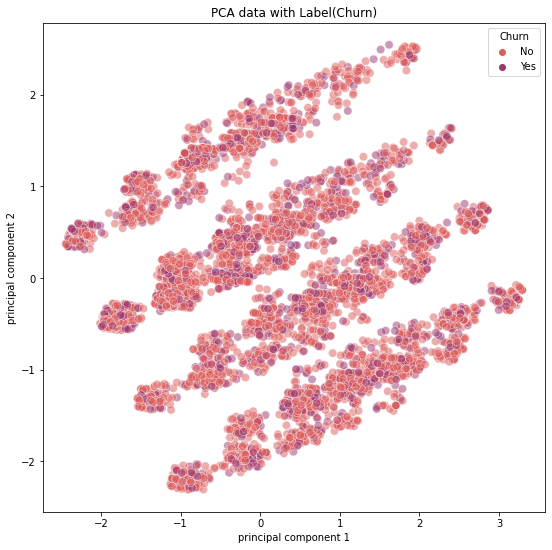

In [11]:
fig = plt.figure(figsize= (9, 9))
fig.set_facecolor('white')

temp['Churn'].replace(to_replace=0.0, value='No', inplace=True)
temp['Churn'].replace(to_replace=1.0, value='Yes', inplace=True)

ax = sns.scatterplot(data=temp, x='principal component 1', y='principal component 2', hue=temp['Churn'], s=70, palette='flare', alpha=0.5)

ax.set_title('PCA data with Label(Churn)')
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

plt.show()

there are no correlation to Churn ratio. However, we can see we can already see there are some cluster formed (4 cluster that shaped like a linear line estimately). Let's try to cluster it K-Means Clustering Algorithm.

## K-Means Clustering

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [13]:
# scale pca 
scaler = MinMaxScaler()
pca_df = scaler.fit_transform(pca_df)
pca_df = pd.DataFrame(pca_df, columns=['principal component 1', 'principal component 2'])


In [14]:
pca_df.head()

,principal component 1,principal component 2
0,0.220057,0.436946
1,0.373152,0.785249
2,0.245687,0.724728
3,0.736052,0.364552
4,0.085828,0.380219


In [15]:
# loop to find best K
silhouette_scores=[]
sse=[]
for i in range(2, 15):
    km = KMeans(n_clusters = i).fit(pca_df)
    pred = km.predict(pca_df)
    centers = km.cluster_centers_

    # get euclidean, silhouette score
    score = silhouette_score (pca_df, pred)
    silhouette_scores.append(score)

    # get sse
    sse.append(km.inertia_)

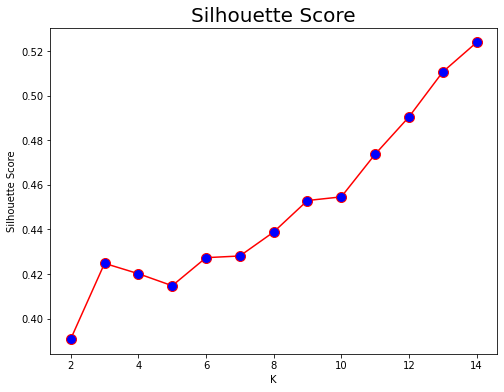

In [16]:
fig = plt.figure(figsize=(8, 6)) 
fig.set_facecolor('white')

plt.plot(range(2, 15), silhouette_scores, color='red', marker='o', markerfacecolor='b', markersize=10)

plt.title('Silhouette Score', size=20)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

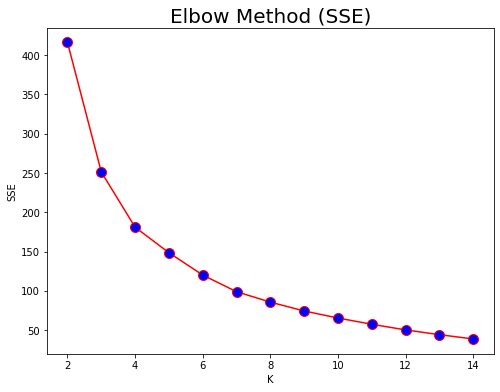

In [17]:
fig = plt.figure(figsize=(8, 6)) 
fig.set_facecolor('white')

plt.plot(range(2, 15), sse, color='red', marker='o', markerfacecolor='b', markersize=10)

plt.title('Elbow Method (SSE)', size=20)
plt.xlabel('K')
plt.ylabel('SSE')
plt.show()

we can't see clearly what k is the best, it show the minimum error and best silgouette score was the highest k (which is k=14) but it most unlikely the pca data was have that much cluster. 

By visualisation of pca data before, we can see 4 cluster form but K-Means seems didn't show this relationship. lets see the K-Means cluster with k=4 

### K-Means, k=4

In [18]:
centroids = np.asarray([[0.3, 0.1],[0.4, 0.3], [0.5, 0.5], [0.6, 0.7]])
km4 = KMeans(n_clusters=4, init=centroids, n_init=1, max_iter=800).fit(pca_df)
km4_pred = km4.predict(pca_df)
print(km4_pred)

[1 3 3 ... 1 1 2]


In [19]:
print(km4.cluster_centers_)

[[0.40461027 0.20773195]
 [0.17107138 0.46552679]
 [0.72870705 0.42238171]
 [0.42578496 0.72685259]]


In [20]:
km4_df = pd.DataFrame(km4_pred, columns=['cluster'])
cluster4 = pd.concat([pca_df, km4_df], axis=1)
cluster4.head()

,principal component 1,principal component 2,cluster
0,0.220057,0.436946,1
1,0.373152,0.785249,3
2,0.245687,0.724728,3
3,0.736052,0.364552,2
4,0.085828,0.380219,1


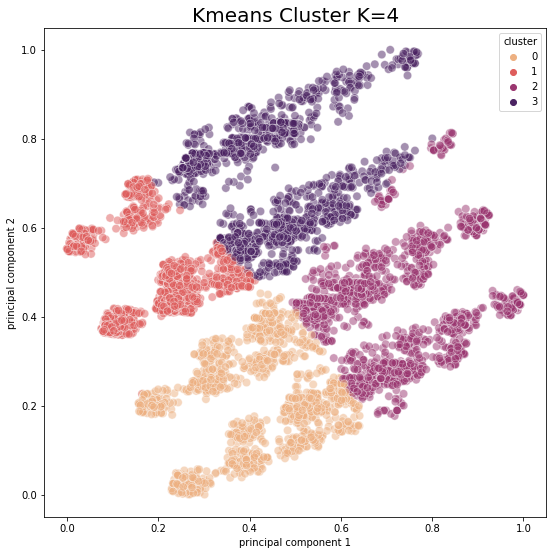

In [21]:
fig = plt.figure(figsize= (9, 9))
fig.set_facecolor('white')

ax = sns.scatterplot(data=cluster4, x='principal component 1', y='principal component 2', hue=cluster4['cluster'], s=70, palette='flare', alpha=0.5)

ax.set_title('Kmeans Cluster K=4', size=20)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

plt.show()

Kmeans cluster with K=4 didn't cluster as what as we expected. It doesn't show any relation for each cluster too. Let's try k=14, which have the best silhouette score and minimum sse from our iteration.

### K-Means, k=14

In [22]:
kkm = KMeans(n_clusters=14).fit(pca_df)
kkm_pred = kkm.predict(pca_df)
kkm_df = pd.DataFrame(kkm_pred, columns=['cluster'])
cluster = pd.concat([pca_df, kkm_df], axis=1)
cluster.head()

,principal component 1,principal component 2,cluster
0,0.220057,0.436946,0
1,0.373152,0.785249,3
2,0.245687,0.724728,3
3,0.736052,0.364552,6
4,0.085828,0.380219,9


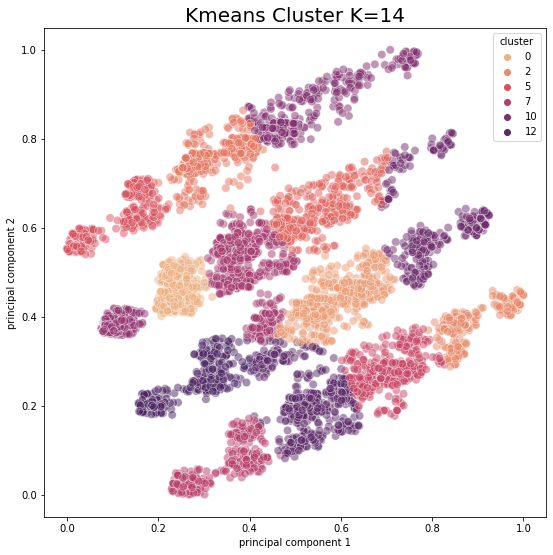

In [23]:
fig = plt.figure(figsize= (9, 9))
fig.set_facecolor('white')

ax = sns.scatterplot(data=cluster, x='principal component 1', y='principal component 2', hue=cluster['cluster'], s=70, palette='flare', alpha=0.5)

ax.set_title('Kmeans Cluster K=14', size=20)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

plt.show()

the cluster seems have too many k and didn;t really shows relationship. Let's try with other algorithm.

## DBSCAN

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
# the best parameter tuning i've tried so far:

# dbscan = DBSCAN(eps=0.031, min_samples=15)
dbscan = DBSCAN(eps=0.03, min_samples=11)
# dbscan = DBSCAN(eps=0.025, min_samples=9)
dbscan = dbscan.fit(pca_df)

In [26]:
dbscan_pred = dbscan.labels_
dbscan_df = pd.DataFrame(dbscan_pred, columns=['cluster'])
cluster_db = pd.concat([pca_df, dbscan_df], axis=1)
cluster_db.head()

,principal component 1,principal component 2,cluster
0,0.220057,0.436946,0
1,0.373152,0.785249,1
2,0.245687,0.724728,1
3,0.736052,0.364552,2
4,0.085828,0.380219,0


In [27]:
n_clusters_ = len(set(dbscan.labels_))
n_noise_ = list(dbscan.labels_).count(-1)

print('est cluster: %d' % n_clusters_)
print('est noise  : %d' % n_noise_)

est cluster: 10
est noise  : 9


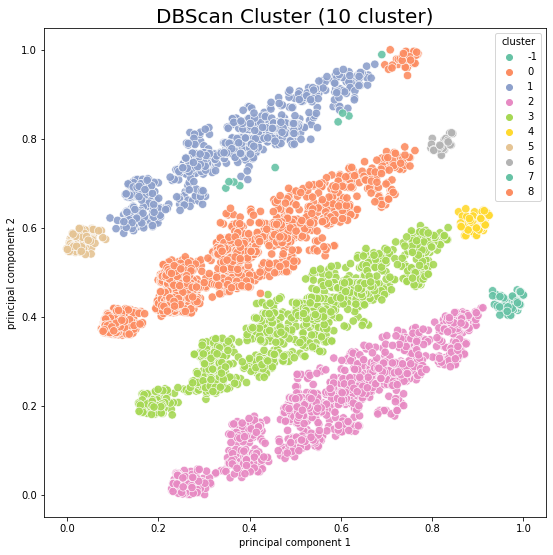

In [28]:
fig = plt.figure(figsize= (9, 9))
fig.set_facecolor('white')

ax = sns.scatterplot(data=cluster_db, x='principal component 1', y='principal component 2', hue=cluster_db['cluster'], s=70, palette='Set2', alpha=0.9)

ax.set_title('DBScan Cluster (10 cluster)', size=20)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

plt.show()

we can see major 4 cluster formed by cluster 1 (blue), cluster 0 (orange), cluster 3 (light green), and cluster 5 (pink)

lets compare DBSCAN to K-Means, with K-Means k=10

In [29]:
kkm = KMeans(n_clusters=10).fit(pca_df)
kkm_pred = kkm.predict(pca_df)
kkm_df = pd.DataFrame(kkm_pred, columns=['cluster'])
cluster = pd.concat([pca_df, kkm_df], axis=1)
cluster.head()

,principal component 1,principal component 2,cluster
0,0.220057,0.436946,4
1,0.373152,0.785249,0
2,0.245687,0.724728,0
3,0.736052,0.364552,2
4,0.085828,0.380219,4


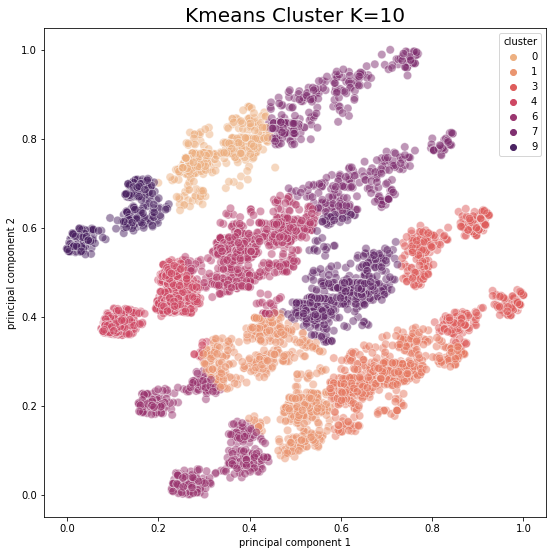

In [30]:
fig = plt.figure(figsize= (9, 9))
fig.set_facecolor('white')

ax = sns.scatterplot(data=cluster, x='principal component 1', y='principal component 2', hue=cluster['cluster'], s=70, palette='flare', alpha=0.5)

ax.set_title('Kmeans Cluster K=10', size=20)
ax.set_xlabel('principal component 1')
ax.set_ylabel('principal component 2')

plt.show()

we can't see simmilar relationship/cluster formed like we see on DBSCAN. K-Means cluster didn't show any relationship at all.